# Multi-Agent Project
---
A multi-agent DDPG framework to solve the Collaboration and Competition Project as part of [Udacity's Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Import the Necessary Packages

In [1]:
import gym
import random
import torch
import math 
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from agent import Agent

from unityagents import UnityEnvironment

### 2. Instantiate the Environment and Agent

Initialize the environment in the code cell below. Depending on the operating system, the ``TENNIS_PATH`` to the Unity environment migth need to change.

In [2]:
TENNIS_PATH = "Tennis.app"

env = UnityEnvironment(file_name=TENNIS_PATH,worker_id=1, seed=1) # Otherwise Unity crashes...
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

env_info = env.reset(train_mode=False)[brain_name]

action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

states = env_info.vector_observations
state_size = states.shape[1]
num_agents = states.shape[0]

print('There are {} agents. Each observes a state with length: {}'.format(num_agents, state_size))
print('The state for the first agent looks like:', states[0])

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Number of actions: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.63803244 -1.5
 -0.          0.          6.00063038  6.         -0.          0.        ]


### 3. Simplify the Interface of the Environment

The environment returns a ``BrainInfo`` object with attributes for the new state, the reward, and other information. The following helper function unpacks the values for ``next_state``, ``reward``, and ``done``.

In [3]:
def open_brain_surgery(brain):
    """Helper function to unpack BrainInfo Object.
    
    Params
    ======
        brain (BrainInfo) : Single BrainInfo Object
    """
    next_state = brain.vector_observations
    reward = brain.rewards
    done = brain.local_done
    return (next_state, reward, done)

### 4. Define the Training Function

The cell below trains the agent from scratch and saves the checkpoints when the environment is solved (average score > 0.5). If ``highscore = True``, the agent continues to train until the maximum number of episodes is reached and saves the model whenever a new highscore is achieved.

In [4]:
def train(n_episodes=5000, highscore=False):
    """Multi Agent Deep Deterministic Policy Gradient.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        highscore (bool): If True training continues after the environment has been solved
    """
    max_score = 0.4                    # keep track of highest winning score
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    for i_episode in range(1, n_episodes+1):
        state, _, _ = open_brain_surgery(env.reset(train_mode=True)[brain_name])
        score = 0
        scores_agents = np.zeros(num_agents) 
        agent.reset()
        while True:
            action = agent.act(state)
            next_state, reward, done = open_brain_surgery(env.step(action)[brain_name])
            agent.step(state, action, reward, next_state, done)
            state = next_state
            scores_agents += reward
            if np.any(done):
                break 
        score = np.mean(scores_agents)    # calculate mean score over agents
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        avg_score = np.mean(scores_window)
        top_score = np.mean(scores_window)
        if i_episode % 100 == 0:            # report training progress
            print('\rEpisode {}\t Best Score: {:.2f}, Average Score: {:.2f}'.format(i_episode, top_score, avg_score))
        if math.floor(avg_score*10)/10 > max_score:
            if max_score == 0.4:          # environment solved (the average score is rounded down)
                print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}\n'.format(i_episode-100, avg_score))
            else:                         # new high score achieved
                print('\nNew high score after {:d} episodes!\tAverage Score: {:.2f}\n'.format(i_episode-100, avg_score))
            max_score = math.floor(avg_score*10)/10
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            if not highscore:
                break
    return scores


def plot_scores(scores):
    """Plot Scores.
    
    Params
    ======
        scores (list): list of score for each episode
    """
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

### 5. Train the Agents

The Agent class contains the DDPG agent.

The number of layers (at least one) and their neurons for the actor and the critic networks can be passed in lists to the hidden_sizes_actor and hidden_sizes_critic parameters. The default is ``hidden_sizes_actor = [64,64]`` for the actor, i.e., two layers with 64 neurons each, and ``hidden_sizes_critic = [128, 64, 32]`` for the critic.

Hyperparameters for the learning process can be changed at the beginning of the ``agent.py`` file and are set to:

- ``BUFFER_SIZE = int(1e5)``

- ``BATCH_SIZE = 128``

- ``GAMMA = 0.99``

- ``TAU = 1e-3``

- ``LR_ACTOR = 1e-4``

- ``LR_CRITIC = 1e-3``

- ``WEIGHT_DECAY_AC = 0``

- ``WEIGHT_DECAY_CR = 0``

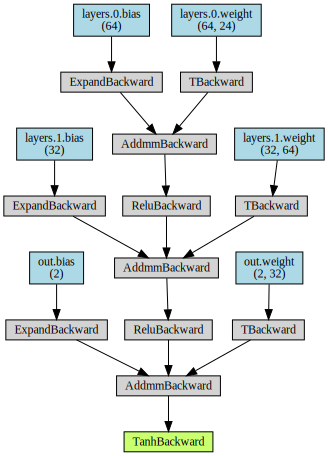

In [5]:
agent = Agent(state_size=state_size, action_size=action_size, 
              random_seed=0, num_agents=num_agents, 
              hidden_sizes_actor=[64,32], hidden_sizes_critic=[128, 64, 32])
agent.show_actor_local()

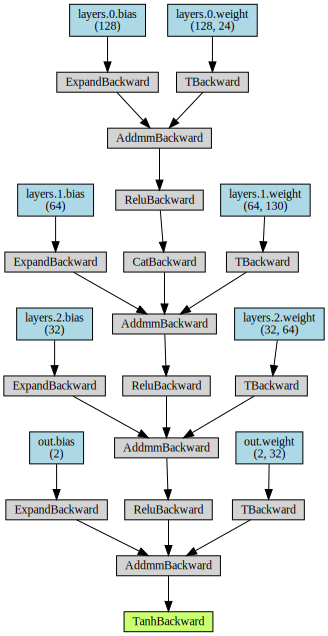

In [6]:
agent.show_critic_local()

Episode 100	 Episode Score: -0.00, Average Score: -0.00
Episode 200	 Episode Score: -0.00, Average Score: -0.00
Episode 300	 Episode Score: -0.00, Average Score: 0.00
Episode 400	 Episode Score: -0.00, Average Score: -0.00
Episode 500	 Episode Score: -0.00, Average Score: -0.00
Episode 600	 Episode Score: -0.00, Average Score: -0.00
Episode 700	 Episode Score: -0.00, Average Score: -0.00
Episode 800	 Episode Score: -0.00, Average Score: 0.01
Episode 900	 Episode Score: -0.00, Average Score: 0.03
Episode 1000	 Episode Score: 0.20, Average Score: 0.07
Episode 1100	 Episode Score: 0.20, Average Score: 0.12
Episode 1200	 Episode Score: -0.00, Average Score: 0.20
Episode 1300	 Episode Score: 2.55, Average Score: 0.45

Environment solved in 1209 episodes!	Average Score: 0.50



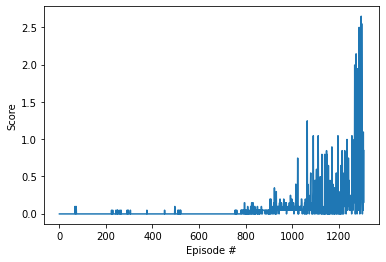

In [7]:
scores = train()
plot_scores(scores)

### 6. Watch the Trained Agents

The next cell loads the checkpoint for a trained agent to watch it in action.

In [8]:
# load the weights from file
def watch_agent(agent, max_t=1000, file_name_actor = None, file_name_critic = None):
    """Watch Trained Agent.
    
    Params
    ======
    file_name_actor (path): path to a trained actor compatible with the agent (optional)
    file_name_critic (path): path to a trained critic compatible with the agent (optional)
    """
    if file_name_actor is None:
        file_name_actor = 'checkpoint_actor.pth'
    if file_name_critic is None:
        file_name_critic = 'checkpoint_critic.pth'
        
    # Load weights
    agent.actor_local.load_state_dict(torch.load(file_name_actor))
    agent.critic_local.load_state_dict(torch.load(file_name_critic))

    # Initiate and run            
    state, _, _ = open_brain_surgery(env.reset(train_mode=False)[brain_name])
    scores_agents = np.zeros(num_agents) 
    agent.reset()
    while True:
        action = agent.act(state)
        next_state, reward, done = open_brain_surgery(env.step(action)[brain_name])
        agent.step(state, action, reward, next_state, done)
        state = next_state
        scores_agents += reward
        if np.any(done):
            break 
    score = np.mean(scores_agents)
    print('Game score: {}'.format(score))
    
watch_agent(agent)

Game score: 1.3450000202283263


In [9]:
env.close()

### 7. Possible Extensions

Performance and training speed could potentially be increased further:

1. The hyperparameters used are likely not optimal. Additional tuning or grid search could be used to make the traing more efficient.
2. The ReplayBuffer class could be appended to support prioritized experience replay.
3. Switching to more advanced algorithms, such as D4PG, A3C, TPRO, or PPO might yield better performance.